# Mixtures of MDPs -- Testbed

In [2]:
import sys
# setting path
sys.path.append('../core')
import os
os.environ["VECLIB_MAXIMUM_THREADS"] = "10"


from sklearn.decomposition import PCA

#bread and butter
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#machine learning library
import sklearn
import sklearn.manifold
import sklearn.cluster
import sklearn.decomposition

#statistics
import scipy
from scipy.stats import rankdata, norm

import numba
from numba import jit, njit

import tqdm
from tqdm import tqdm
import copy
import cvxpy as cp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#import numpy as tnp
import warnings
warnings.filterwarnings('ignore')


import os
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import scipy

import confound_mdp
import confound_ope
import confound_env
import copy

from subspace import *
from clustering import *
from emalg import *
from helpers import *

%matplotlib inline
plt.style.use('matplotlibrc')

2023-03-18 13:58:22.622561: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-18 13:58:22.674292: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-18 13:58:22.931926: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-18 13:58:22.931952: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

In [3]:
envs = []
# each row:
#   [mdp , pi_b, pi_e, horizon, gamma, nStates, nActions, term]


horizon = 100 #18
#, slip = 0.04, confound_weight=0.6
pi_b, P, R, x_dist, u_dist, gamma = confound_env.gridworld_opetools(horizon = horizon, slip = 0.04, 
                                                                    confound_weight=0.6, small=True, soft=True)
#R = -1*R
gridworld = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

nStates = P.shape[2]
nActions = P.shape[1]

pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.4, 0.1, 0.4, 0.1]
    
envs.append([gridworld, pi_b, pi_e, horizon, gamma, nStates, nActions, -1, P, R, x_dist, u_dist, gamma])



In [4]:
for mdp , pi_b, pi_e, base_horizon, gamma, nStates, nActions, term, P, R, x_dist, u_dist, gamma in [envs[-1]]:
    
    print("---")
    
    print("running env with horizon", horizon)

    #dataset = confound_mdp.collect_sample(int(100), mdp, pi_b, horizon, iid=False)
    #pi_b = np.array([pi_b.mean(0),pi_b.mean(0)])
    dataset = getSamplesMultiProc(10000, mdp, pi_b, horizon, iid=False)
    data = dataset.reshape((dataset.shape[0]*dataset.shape[1],5))
    Phat = confound_ope.estimate_P(dataset, mdp)
    pihat = confound_ope.estimate_pi(dataset, mdp)
    for a in range(nActions):
        for s in range(nStates):
            if Phat[a,s].sum() == 0:
                Phat[a,s,term] = 1
            if pihat[s].sum() == 0:
                pihat[s,:] = 1/nActions
    pi_avg = pi_b[0] * u_dist[0] + pi_b[1] * u_dist[1]

    # This is the actual reward_sa
    # P(s,a,s') * R(s,a,s')
    # R(s,a) = \Sum_{s'} P(s,a,s') * R(s,a,s')
    R_sa = (np.average(P, axis=0, weights=u_dist) * R).sum(axis=2).T #np.sum(R, axis=2).T #.reshape(nStates, nActions)
    P_spsa = Phat.transpose((2, 1, 0))
    n = data.shape[0]


     # behavior value
    print("value of pi_b")
    returns = confound_mdp.calc_returns(dataset, gamma, horizon)
    print(returns.mean())

---
running env with horizon 100
value of pi_b
-1.6113588791501188


In [5]:
from numba import njit
#Ptrue_spsa = np.einsum('u,uasp->psa', u_dist, P)
#pi_bsa = np.einsum('u,usa->sa', u_dist, pi_b)
#Pb_spsa = getPb_spsa(nStates, nActions, u_dist, pi_b, pi_bsa, P)

burnin = 0
N_sa = getN_sa(dataset, nStates, nActions, burnin=0)

In [5]:
#plt.figure(figsize=(16,9))
#plt.plot((Pb_spsa - P_spsa).transpose(1,2,0).reshape(nStates*nActions, nStates))
#plt.suptitle('bias = true - estim')
#plt.legend()

In [6]:
# x, a, u, x', r
dataset.shape

(9984, 100, 5)

In [6]:
stateactions = dataset[:, :, [0, 1]]
X = stateactions.reshape(stateactions.shape[0], stateactions.shape[1]*stateactions.shape[2])
fullX = dataset.reshape(dataset.shape[0], dataset.shape[1]*dataset.shape[2])

memorder = 'C'

#threes = dataset.reshape(int(dataset.shape[0] * dataset.shape[1] / 3), 3, dataset.shape[2])
concattrajs = dataset.reshape(dataset.shape[0]*dataset.shape[1], dataset.shape[2])
threes = np.array([concattrajs[i:i+3] for i in range(len(concattrajs)-2)])
print(threes.shape)
threes = dataset #comment for non-sanity check
print(threes.shape)
if memorder == 'F':
    stateactions = (threes[:,:,0] + threes[:,:,1]*nStates).astype(int) #we code (S x A) as s + a|S|, 0,16,32,48 1,17,33,49
else:
    stateactions = (threes[:,:,0]*nActions + threes[:,:,1]).astype(int)
states = (threes[:,:,0]).astype(int)
actions = (threes[:,:,1]).astype(int)
currstates = threes[:,:,[0,1]].astype(int)
confounders = threes[:,:,2].astype(int)
labels = confounders[:,0].astype(int)
nextstates = threes[:,:,3].astype(int)

L = 2
K = 2
#S = nStates*nActions
#N = len(threes)

(998398, 3, 5)
(9984, 100, 5)


## Distributions over States and Actions over Time

So now we have our dataset encoded in something isomorphic to state-action tuples, we can take a look at mixing times. On a 4x4 gridworld, 15, 31, 47 and 63 correspond to the goal state under Fortran ordering. Under C ordering, it's 60, 61, 62, 63. Here's a plot of the distribution over state-action tuples over time.

In [6]:
np.array([np.bincount(states[:, 0].astype(int)[labels==i])/sum(labels==i) for i in range(max(labels+1))]).shape

(2, 16)

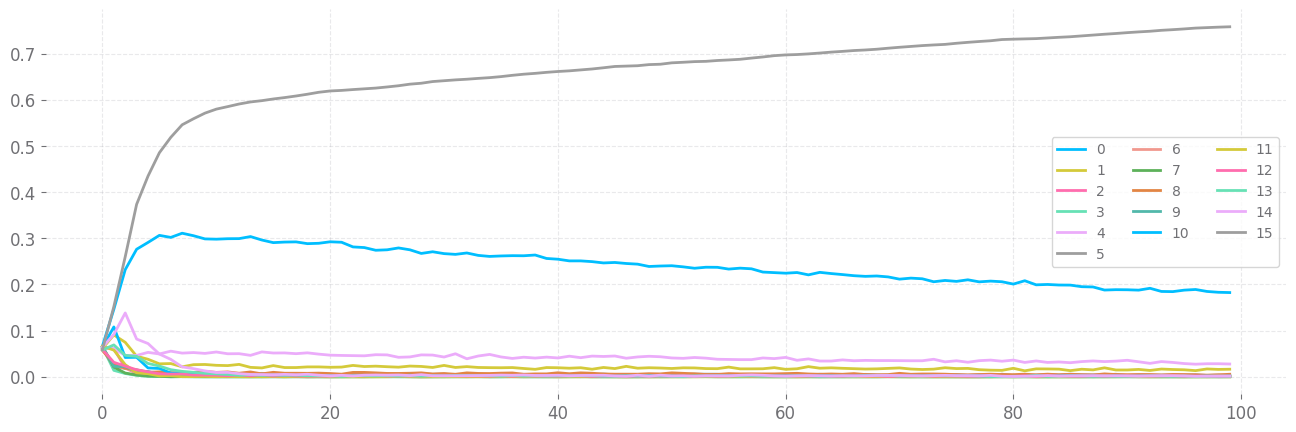

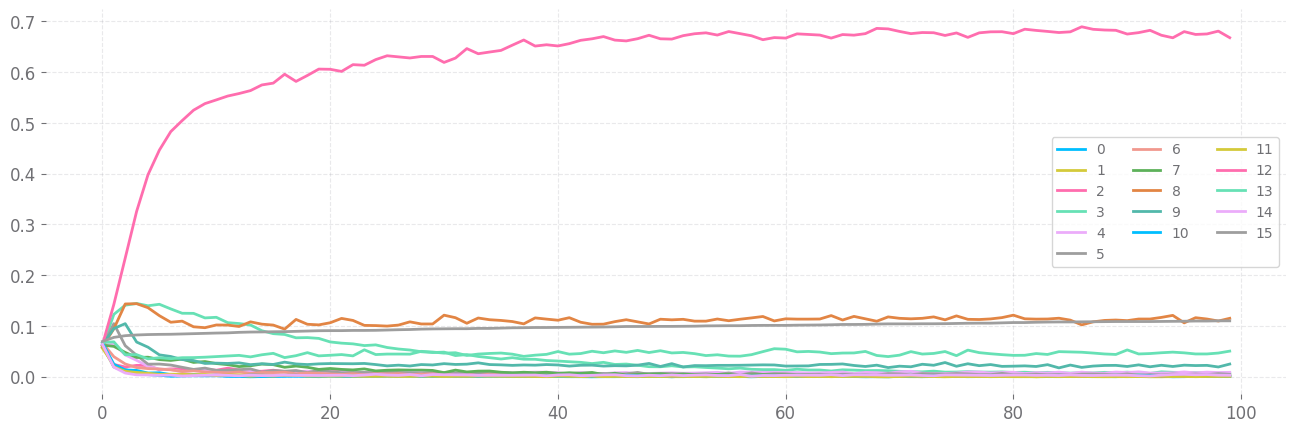

In [7]:
dist = np.array([np.bincount(states[:, i].astype(int)[labels==0], minlength=nStates) 
         for i in range(states.shape[1])])/sum(labels==0)
pd.DataFrame(dist).plot(figsize=(16,5))
plt.legend(ncol=3)
dist = np.array([np.bincount(states[:, i].astype(int)[labels==1], minlength=nStates) 
         for i in range(states.shape[1])])/sum(labels==1)
pd.DataFrame(dist).plot(figsize=(16,5))
plt.legend(ncol=3)

In [14]:
dist.shape

(100, 64)

In [13]:
stateactions.shape

(9984, 100)

<AxesSubplot: >

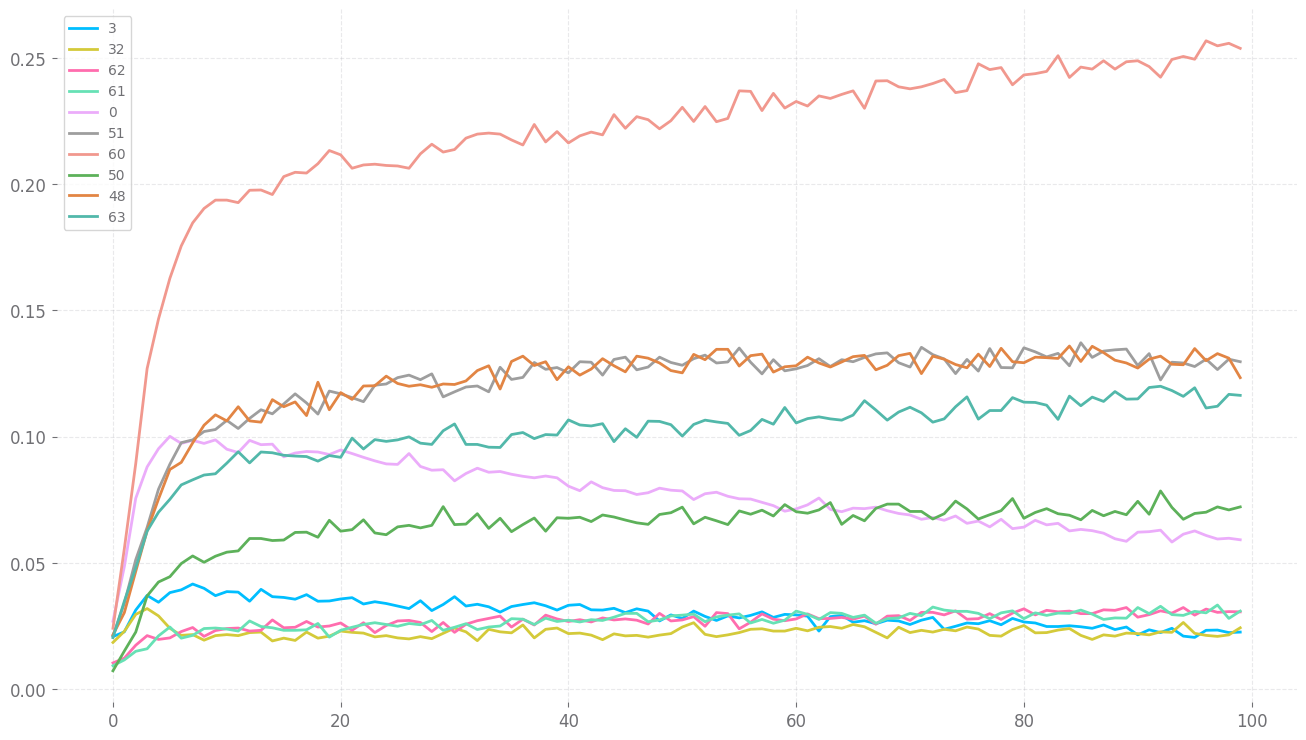

In [9]:
dist = np.array([np.bincount(stateactions[:, i].astype(int), minlength=nStates*nActions) 
         for i in range(stateactions.shape[1])])/len(labels)
pd.DataFrame(dist[:,np.argpartition(dist[-1,:], -10)[-10:]], 
            columns = np.argpartition(dist[-1,:], -10)[-10:]).plot(figsize=(16,9))
#pd.DataFrame(dist[:,[15,31,47,63]]/100000, 
#            columns = [15,31,47,63]).plot(figsize=(16,9))

## Mixing Time Check

And here's a plot of the L1-norm between distributions at step t and step t+1 over time. This converges really quickly to something in the neighborhood of 0.02. 

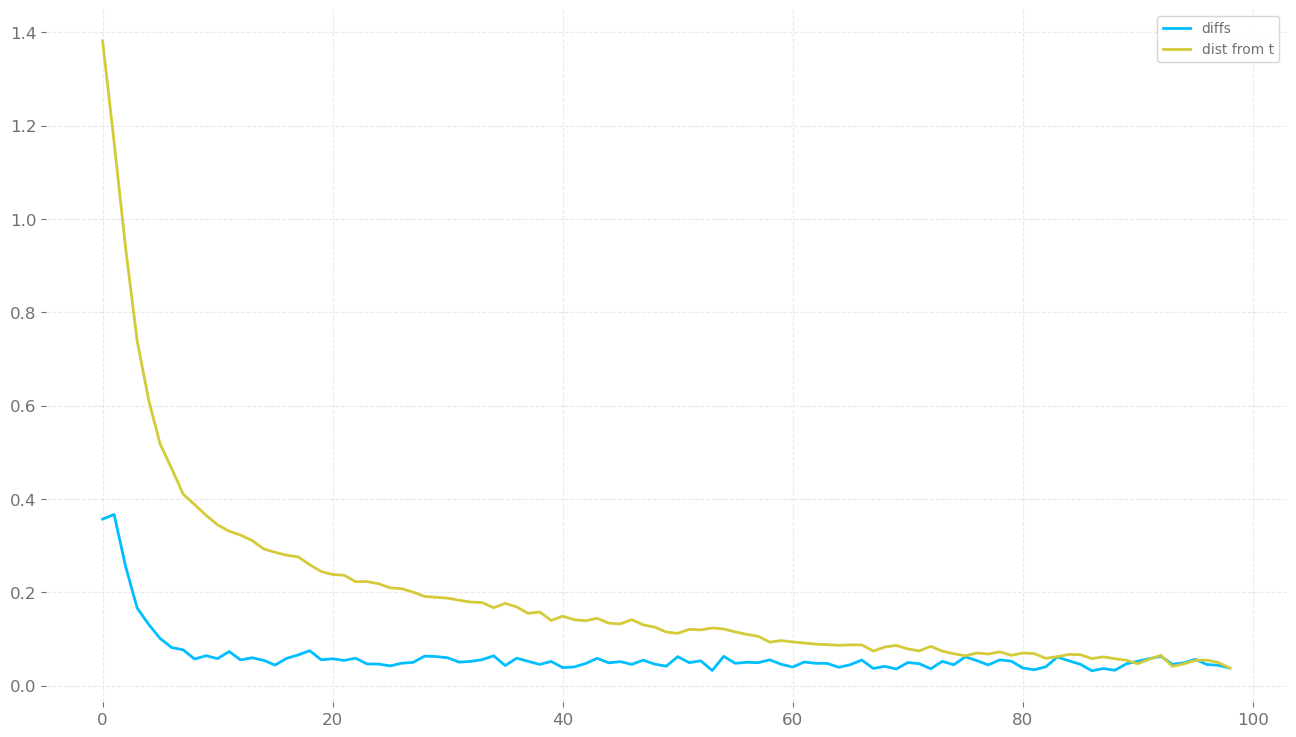

In [11]:
plt.figure(figsize=(16,9))
plt.plot(np.sum(np.abs(np.diff(dist, axis=0)),1), label='diffs')
plt.plot(np.sum(np.abs(dist - dist[-1])[:-1],1), label='dist from t')
plt.legend()

## Subspace Estimation

In [7]:
sadim = nStates*nActions
spdim = nStates
omegaone = np.array([i for i in range(int(horizon/4), 2*int(horizon/4))])
omegatwo = np.array([i for i in range(3*int(horizon/4), horizon)])
onehotsa = np.eye(int(np.max(stateactions))+1)[stateactions]
onehotsaflat = copy.deepcopy(onehotsa)
onehotsa = onehotsa.reshape((onehotsa.shape[0], onehotsa.shape[1], nStates, nActions), order=memorder)
onehotsp = np.eye(np.max(nextstates)+1)[nextstates]
sz = int(onehotsa.shape[0]/3)

In [21]:
onehotsa.shape

(9984, 100, 16, 4)

In [8]:
onehotsasub = onehotsa[:sz]
onehotsaflatsub = onehotsaflat[:sz]
onehotspsub = onehotsp[:sz]

onehotsaclust = onehotsa[sz:]
onehotsaflatclust = onehotsaflat[sz:]
onehotspclust = onehotsp[sz:]

In [14]:
#np.array([i for i in range(64)]).reshape(nStates, nActions, order=memorder)
#so it turns out the s + a|S| ordering corresponds to Fortran ordering

In [9]:
eigvalsa, eigvecsa = getEig(onehotsasub, onehotspsub, omegaone, omegatwo, K, wt=True)

In [10]:
eigvalsp, eigvecsp = getEigKs(onehotsasub, onehotspsub, omegaone, omegatwo, K)

In [11]:
vals, vecs = getEig(onehotsasub, onehotspsub, omegaone, omegatwo, 10000, wt=True)

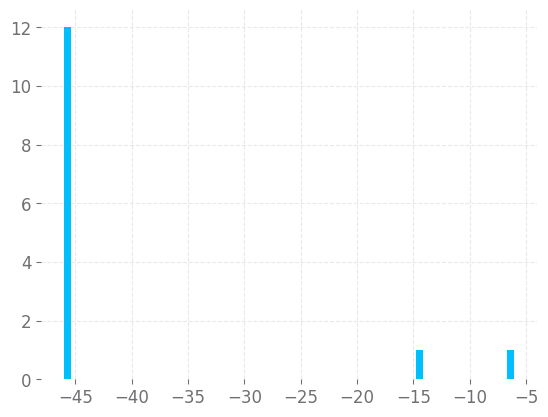

In [26]:
plt.hist(np.log(vals[1,0]+1e-20), bins=64) #(s,a,eigs)
plt.show()

## Clustering

In [27]:
%load_ext autoreload
%autoreload 2
from clustering import *
import clustering

In [12]:
def computeStat(hs, eigvecsa, numpy=True, smalldata=True, device='/CPU:0', proj=True):
    if numpy:
        if proj:
            #2, nTraj, S, A, 1, K
            projs = (hs[..., None,:] @ eigvecsa[None,...]).squeeze(4)
        else:
            projs = hs
        if smalldata:
            statmns = np.max(
                        np.nansum(
                            (projs[0,None,...] - projs[0,:,None,...]) * 
                            (projs[1,None,...] - projs[1,:,None,...]), 
                        axis=-1), 
                    axis=(2,3))
        else:
            statmns = np.zeros((projs.shape[1], projs.shape[1]))
            for s in tqdm(range(projs.shape[2])):
                for a in range(projs.shape[3]):
                    newstats = np.nansum((projs[0, None, :, s, a, :] - projs[0, :, None, s, a, :]) * 
                                (projs[1, None, :, s, a, :] - projs[1, :, None, s, a, :]), -1)
                    statmns = np.maximum(statmns, 
                       newstats)
        return statmns
    else:
        with tf.device(device):
            hs = tf.convert_to_tensor(hs, np.float32)
            eigvecsa = tf.convert_to_tensor(eigvecsa, np.float32)
            if proj:
                projs = tf.squeeze(hs[..., None,:] @ eigvecsa[None,...], axis=4)
            else:
                projs = hs
            if smalldata:
                statmns = tf.reduce_max(
                                    tf.reduce_sum(
                                        (projs[0,None,...] - projs[0,:,None,...]) * 
                                        (projs[1,None,...] - projs[1,:,None,...]), 
                                    axis=-1), 
                            axis=(2,3)).numpy()
            else:
                statmns = tf.zeros((projs.shape[1], projs.shape[1]), dtype=tf.float32)
                for s in tqdm(range(projs.shape[2])):
                    for a in range(projs.shape[3]):
                        newstats = tf.reduce_sum((projs[0, None, :, s, a, :] - projs[0, :, None, s, a, :]) * 
                                    (projs[1, None, :, s, a, :] - projs[1, :, None, s, a, :]), -1)
                        statmns = tf.math.maximum(statmns, newstats)
                statmns = statmns.numpy()
        return statmns

In [13]:
device = "/GPU:0"

hs = np.array([geth(onehotsaclust[:,omegaone,:,:], 
                                     onehotspclust[:,omegaone,:]), 
                              geth(onehotsaclust[:,omegatwo,:,:], 
                                   onehotspclust[:,omegatwo,:])])

statmns = computeStat(hs, 
                      eigvecsa, numpy=True, smalldata=False, device=device, proj=True)
statmns.shape

100%|██████████| 16/16 [01:14<00:00,  4.64s/it]


(6656, 6656)

In [15]:
np.mean(statmns == 0)

0.15988854402621117

In [16]:
np.diag(statmns).shape[0]/(statmns.shape[0] ** 2)

0.00015024038461538462

<BarContainer object of 100 artists>

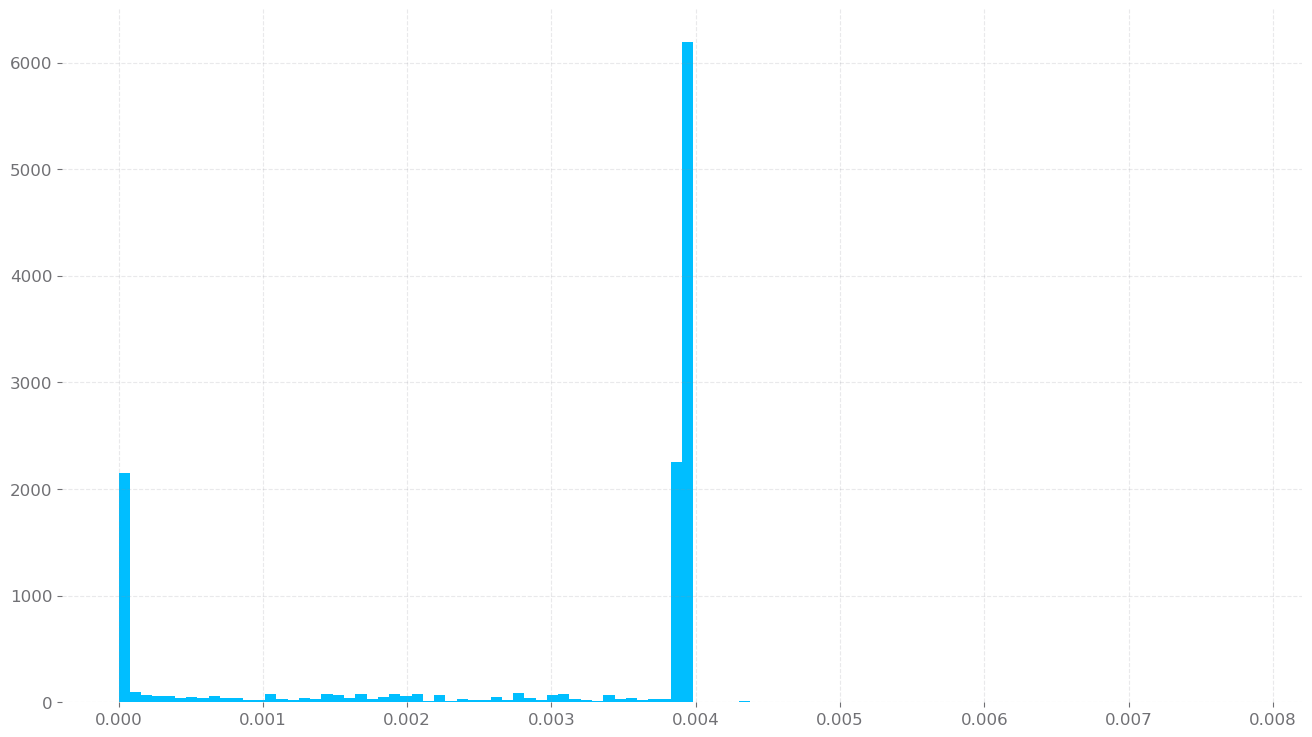

In [21]:
import seaborn as sns
plt.figure(figsize=(16,9))
plt.hist(statmns.flatten(), bins=100, density=True)[2]
#plt.hist(statmns.flatten(), bins=onehotsaclust.shape[0], density=True)[2]
#sns.kdeplot(statmns.flatten(), bw_adjust=0.5)

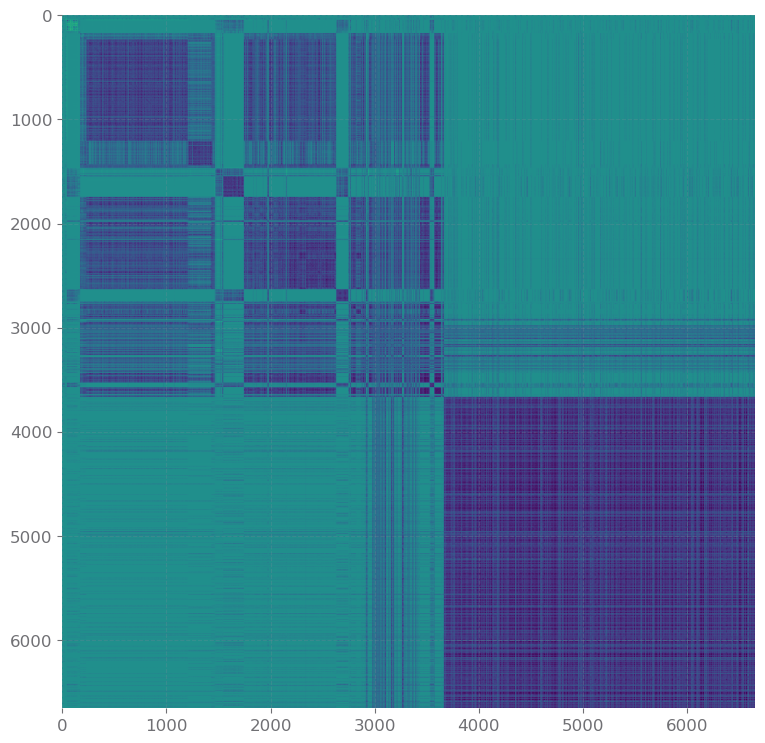

In [22]:
from scipy.cluster.hierarchy import linkage

m = 1-statmns #need similarity matrix
# shuffle
perm = np.random.permutation(len(m))
m = m[perm][:, perm]

# reorder
y = m[np.triu_indices(len(m), k=1)]
Z = linkage(y, method='single', optimal_ordering=True)
perm = np.ravel(Z[:, :2]).astype(np.int32)
perm = perm[perm < len(m)]
m = m[perm][:, perm]

plt.figure(figsize=(16,9))
plt.imshow(1-m)

100%|██████████| 20/20 [01:06<00:00,  3.31s/it]


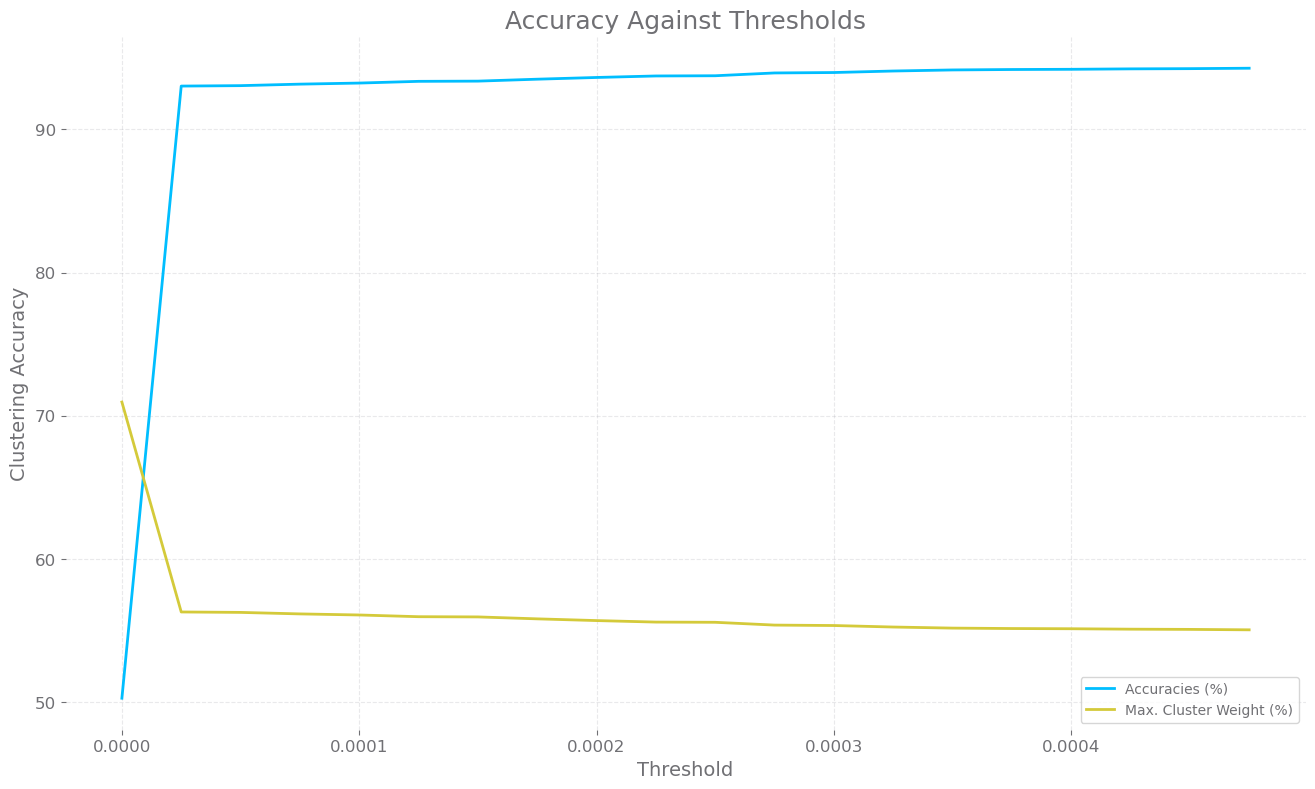

In [23]:
clusterDiagnostics(statmns, K=K, labels=confounders[sz:, 0],
                   lo=0, hi=0.0005, step=0.000025) #0,0.01, 0.0001

In [24]:
tsne = sklearn.manifold.TSNE(n_components=2, perplexity=5.0, 
                             metric='precomputed').fit_transform(statmns) #1-(statmns2 < 0.002)

Text(0.5, 0.98, 't-SNE Visualizations of Clusters and Confounders, Thresholded Distances')

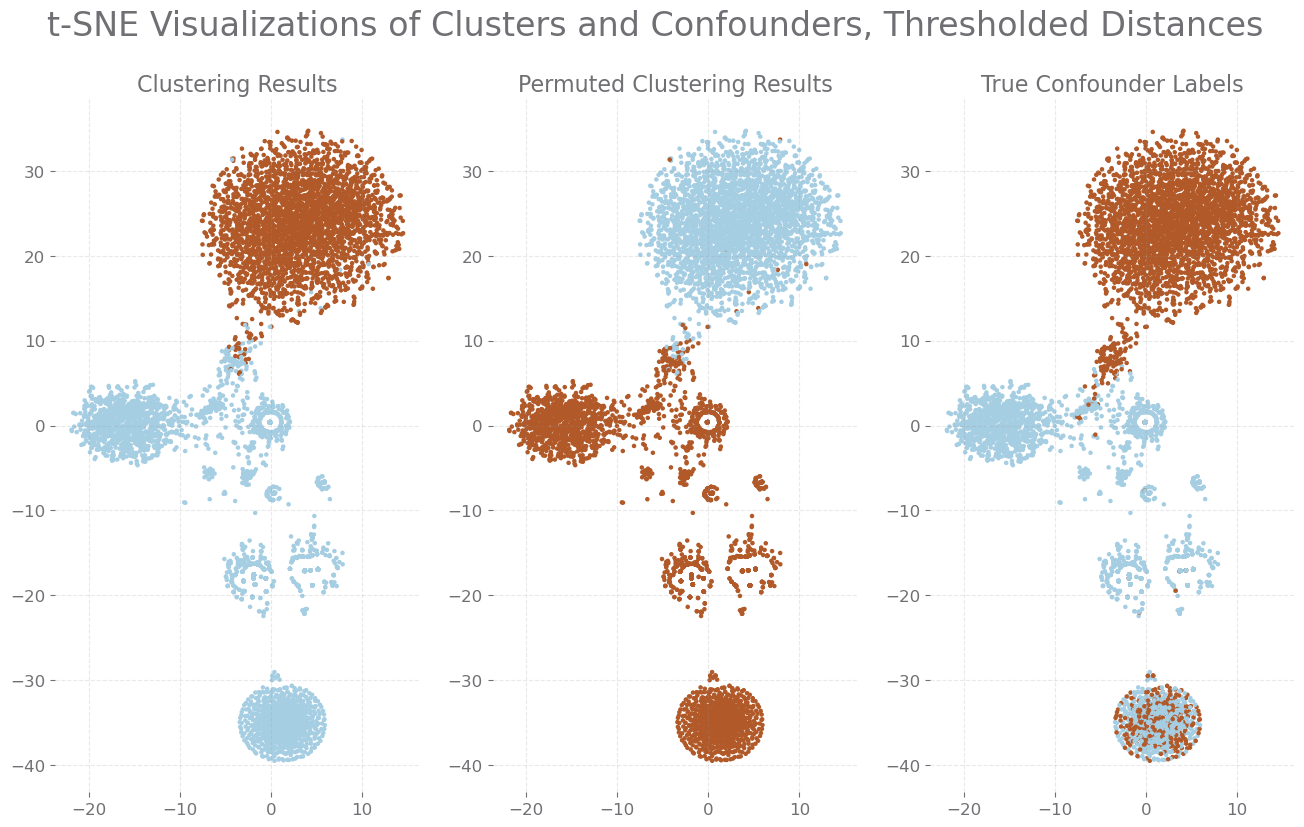

In [25]:
clusterlabs = sklearn.cluster.spectral_clustering((statmns < 0.0001).astype(int), n_clusters=K,
                                                     assign_labels='kmeans')
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((16,9)))
axes[0].scatter(tsne[:,0], tsne[:,1], c=clusterlabs, cmap='Paired', s=5)
axes[1].scatter(tsne[:,0], tsne[:,1], c=1-clusterlabs, cmap='Paired', s=5)
axes[2].scatter(tsne[:,0], tsne[:,1], c=labels[sz:], cmap='Paired', s=5)
axes[0].set_title('Clustering Results', fontsize=16)
axes[1].set_title('Permuted Clustering Results', fontsize=16)
axes[2].set_title('True Confounder Labels', fontsize=16)
fig.suptitle('t-SNE Visualizations of Clusters and Confounders, Thresholded Distances', fontsize=24)

In [26]:
permutation = np.argmax([np.mean(clusterlabs == confounders[sz:, 0]), 
                    np.mean(clusterlabs != confounders[sz:, 0])])
print(permutation, np.max([np.mean(clusterlabs == confounders[sz:, 0]), 
                    np.mean(clusterlabs != confounders[sz:, 0])]))

0 0.9323918269230769


(array([3733.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2923.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

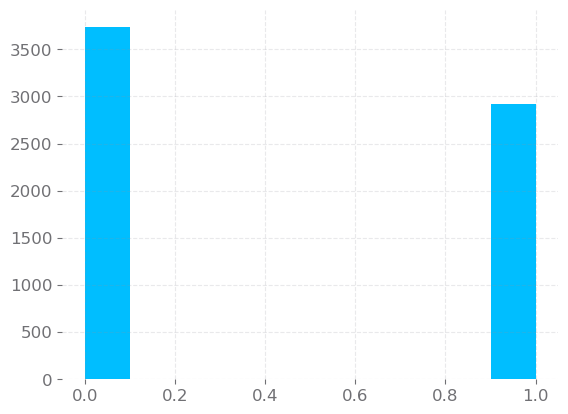

In [27]:
plt.hist(clusterlabs)

## Model Estimation

In [28]:
Phat_ksa = getModelEstim(clusterlabs.astype(int), 
                         states[sz:,:], 
                         actions[sz:,:], 
                         nextstates[sz:,:],
                        K=K, nStates=nStates, nActions=nActions, hard=True)

## Classification

In [29]:
np.bincount(clusterlabs)/len(clusterlabs) 

array([0.56084736, 0.43915264])

In [30]:
#denoised model estimate
Phat_ksad = np.array([eigvecsa @ eigvecsa.transpose(0,1,3,2) @ Phat_ksa[k,:,:,:,None] for k in range(K)]).squeeze()
#projected models
projPhat = np.array([eigvecsa.transpose(0,1,3,2) @ Phat_ksa[k,:,:,:,None] for k in range(K)]).squeeze()


priorclass = np.bincount(clusterlabs)/len(clusterlabs) 
piclust = getPolicyEstim(states[sz:], actions[sz:], 
                         K, nStates, nActions, preds=clusterlabs, hard=True)

startweights = getStartWeights(states[sz:], clusterlabs, K, nStates)
maxapos = classify(Phat_ksa, states, actions, 
                       nextstates, piclust, reg=1, 
                   prior=priorclass, startweights = startweights, labs=True)
mle = classify(Phat_ksa, states, actions, 
                       nextstates, piclust, reg=0, 
               prior=priorclass, startweights = startweights, labs=True)
mleprobs = classify(Phat_ksa, states, actions, 
                       nextstates, piclust, reg=1, 
                    prior=priorclass, startweights = startweights, labs=False)

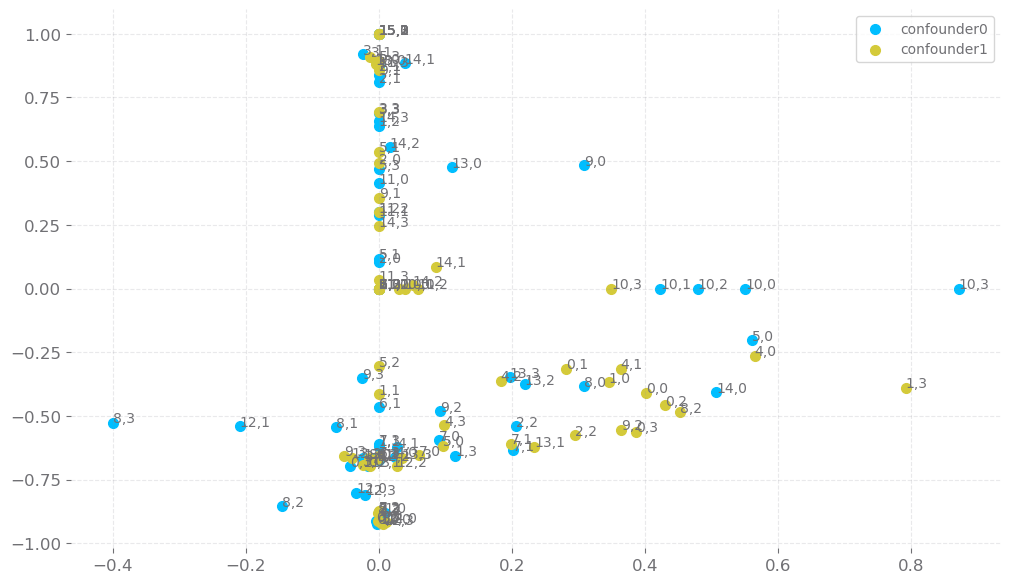

In [31]:
plt.figure(figsize=(12,7))
plt.scatter(projPhat.reshape(K, nStates*nActions, K)[0,:,0], projPhat.reshape(K, nStates*nActions, K)[0,:,1], label='confounder0')
plt.scatter(projPhat.reshape(K, nStates*nActions, K)[1,:,0], projPhat.reshape(K, nStates*nActions, K)[1,:,1], label='confounder1')
for s in range(nStates):
    for a in range(nActions):
        for k in range(K):
            plt.text(projPhat[k,s,a,0], projPhat[k,s,a,1], s=(str(s)+','+str(a)))
plt.legend()

In [32]:
np.mean(labels[2*sz:] == maxapos)
print('MAP estimate accuracy:', [np.mean(labels == maxapos), np.mean(labels != maxapos)][permutation])
print('MLE accuracy:', [np.mean(labels == mle), np.mean(labels != mle)][permutation])

MAP estimate accuracy: 0.9610376602564102
MLE accuracy: 0.9610376602564102


In [33]:
%load_ext autoreload
%autoreload 2
from subspace import *
from clustering import *
from emalg import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
expectclass, modelestimclass, loglikclass = em(maxapos, 
                            Phat_ksa, states, actions, 
                        nextstates, labels=labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 1, max_iter=100,
                                               permute=False, permutation=permutation,
                                               checkin=1, hard=True)

iteration 1 diff 19.797779990737283
9984 9984
accuracy: 0.9610376602564102
-341352.62787556014
iteration 2 diff 0.0
9984 9984
accuracy: 0.9610376602564102
-341352.62787556014
iteration 3 diff 0.0
9984 9984
accuracy: 0.9610376602564102
-341352.62787556014
iteration 4 diff 0.0
9984 9984
accuracy: 0.9610376602564102
-341352.62787556014
iteration 5 diff 0.0
9984 9984
accuracy: 0.9610376602564102
-341352.62787556014
iteration 6 diff 0.0
9984 9984
accuracy: 0.9610376602564102
-341352.62787556014
iteration 7 diff 0.0
9984 9984
accuracy: 0.9610376602564102
-341352.62787556014
iteration 8 diff 0.0
9984 9984
accuracy: 0.9610376602564102
-341352.62787556014
iteration 9 diff 0.0
9984 9984
accuracy: 0.9610376602564102
-341352.62787556014
iteration 10 diff 0.0
9984 9984
accuracy: 0.9610376602564102
-341352.62787556014
log-likelihood: -341352.62787556014


In [35]:
regprobs = 0.8*(np.exp(mleprobs)/np.nansum(np.exp(mleprobs), 0)) + 0.1*np.ones(mleprobs.shape)
expectclasssoft, modelestimclasssoft, loglikclasssoft = em(regprobs, 
                            Phat_ksa, states, actions, 
                        nextstates, labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 1, permute=False, permutation=permutation, checkin=1, hard=False)

iteration 1 diff 23.438113579284682
9984 9984
accuracy: 1.0
-346097.16085871414
iteration 2 diff 32.998509551028285
9984 9984
accuracy: 1.0
-341199.7339143343
iteration 3 diff 1.42059056447771
9984 9984
accuracy: 1.0
-341147.0601468952
iteration 4 diff 8.410286356234963e-14
9984 9984
accuracy: 1.0
-341147.0601468952
iteration 5 diff 5.877805883147021e-48
9984 9984
accuracy: 1.0
-341147.0601468952
iteration 6 diff 8.212078617994426e-70
9984 9984
accuracy: 1.0
-341147.0601468952
iteration 7 diff 1.1473368942775209e-91
9984 9984
accuracy: 1.0
-341147.0601468952
iteration 8 diff 1.6029827447222776e-113
9984 9984
accuracy: 1.0
-341147.0601468952
iteration 9 diff 2.2395807244692814e-135
9984 9984
accuracy: 1.0
-341147.0601468952
iteration 10 diff 3.12899288401631e-157
9984 9984
accuracy: 1.0
-341147.0601468952
log-likelihood: -341147.0601468952


## Stable Baselines: EM Algorithm Alone

In [36]:
randlabs = np.random.binomial(1, 0.5, size=len(dataset)).astype(int)
randmodel = getModelEstim(randlabs, states, actions, nextstates, 
                          K, nStates, nActions, hard=True)
randlabs, randmodel, loglikrand = em(randlabs, randmodel,
   states, actions, nextstates, labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 0, permute=True, permutation=True, checkin=1, hard=True)

iteration 1 diff 0.0
9984 9984
accuracy: 0.6730769230769231
-357733.58062584815
iteration 2 diff 12.023839789543054
9984 9984
accuracy: 0.9229767628205128
-355007.15391344216
iteration 3 diff 26.708410782676232
9984 9984
accuracy: 0.9998998397435898
-346104.3796009519
iteration 4 diff 34.990481763174145
9984 9984
accuracy: 1.0
-341154.8661634973
iteration 5 diff 0.42061094792071796
9984 9984
accuracy: 1.0
-341147.0601468952
iteration 6 diff 0.0
9984 9984
accuracy: 1.0
-341147.0601468952
iteration 7 diff 0.0
9984 9984
accuracy: 1.0
-341147.0601468952
iteration 8 diff 0.0
9984 9984
accuracy: 1.0
-341147.0601468952
iteration 9 diff 0.0
9984 9984
accuracy: 1.0
-341147.0601468952
iteration 10 diff 0.0
9984 9984
accuracy: 1.0
-341147.0601468952
log-likelihood: -341147.0601468952


In [37]:
unifs = np.random.uniform(size=len(dataset))
randlabsoft = np.vstack([unifs, 1-unifs])
randmodelsoft = getModelEstim(randlabsoft, states, actions, nextstates,
                              K, nStates, nActions, hard=False)
randlabsoft, randmodelsoft, loglikrandsoft = em(randlabsoft, randmodelsoft,
   states, actions, nextstates, labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, min_iter = 20, reg = 0, permute=True, permutation=True, checkin=5, hard=False)

iteration 5 diff 15.538970016030381
9984 9984
accuracy: 0.9970953525641025
-350055.7795379803
iteration 10 diff 4.6044749125861426e-55
9984 9984
accuracy: 1.0
-341147.0601468952
iteration 15 diff 2.634445287418248e-164
9984 9984
accuracy: 1.0
-341147.0601468952
iteration 20 diff 1.5072955318999838e-273
9984 9984
accuracy: 1.0
-341147.0601468952
log-likelihood: -341147.0601468952


In [38]:
labelsemsoft = []
logliksemsoft = []
for i in tqdm(range(30)):
    unifs = np.random.uniform(size=len(dataset))
    randlabsoft = np.vstack([unifs, 1-unifs])
    randmodelsoft = getModelEstim(randlabsoft, states, actions, nextstates,
                              K, nStates, nActions, hard=False)
    randlabsoft, randmodelsoft, loglikrand = em(randlabsoft, randmodelsoft,
   states, actions, nextstates, labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=False)
    labelsemsoft.append(randlabsoft)
    logliksemsoft.append(loglikrand)

100%|██████████| 30/30 [00:19<00:00,  1.58it/s]


In [39]:
labelsem = []
logliksem = []
for i in tqdm(range(30)):
    randlabs = np.random.binomial(1, 0.5, size=len(dataset)).astype(int)
    randmodel = getModelEstim(randlabs, states, actions, nextstates,
                              K, nStates, nActions, hard=True)
    randlabs, randmodel, loglikrand = em(randlabs, randmodel,
       states, actions, nextstates, labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=True)
    labelsem.append(randlabs)
    logliksem.append(loglikrand)

100%|██████████| 30/30 [00:12<00:00,  2.45it/s]


0.8733306623931624
0.998046875
1.0


Text(0.5, 1.0, 'Randomly Initialized Hard EM Algorithm')

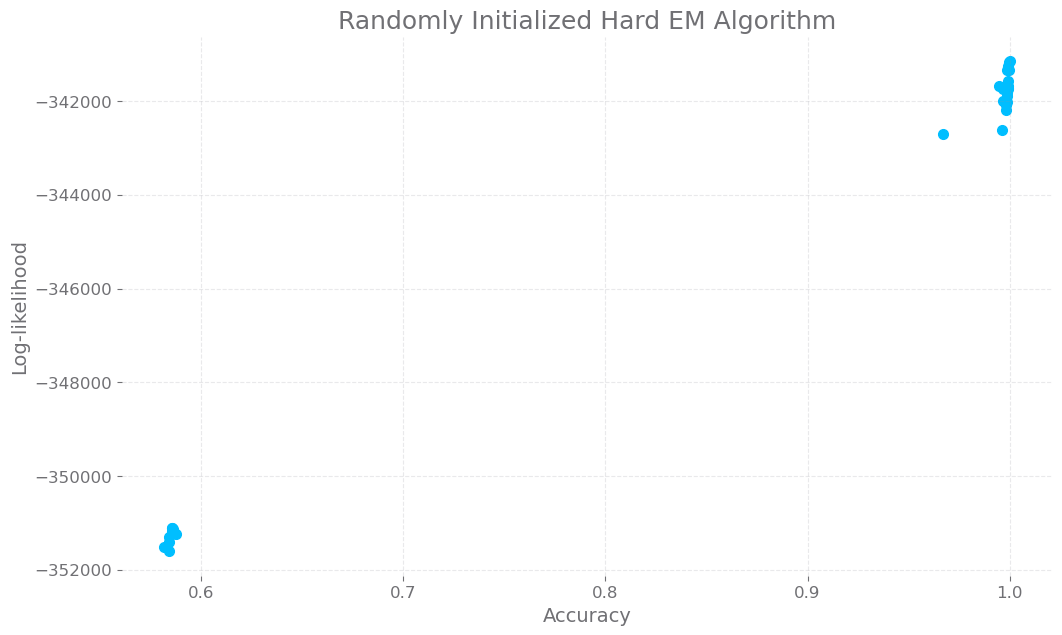

In [40]:
plt.figure(figsize=(12,7))
plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem], logliksem)
print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
plt.xlabel('Accuracy')
plt.ylabel('Log-likelihood')
plt.title('Randomly Initialized Hard EM Algorithm')

0.9311064369658121
1.0
1.0


Text(0.5, 1.0, 'Randomly Initialized Soft EM Algorithm')

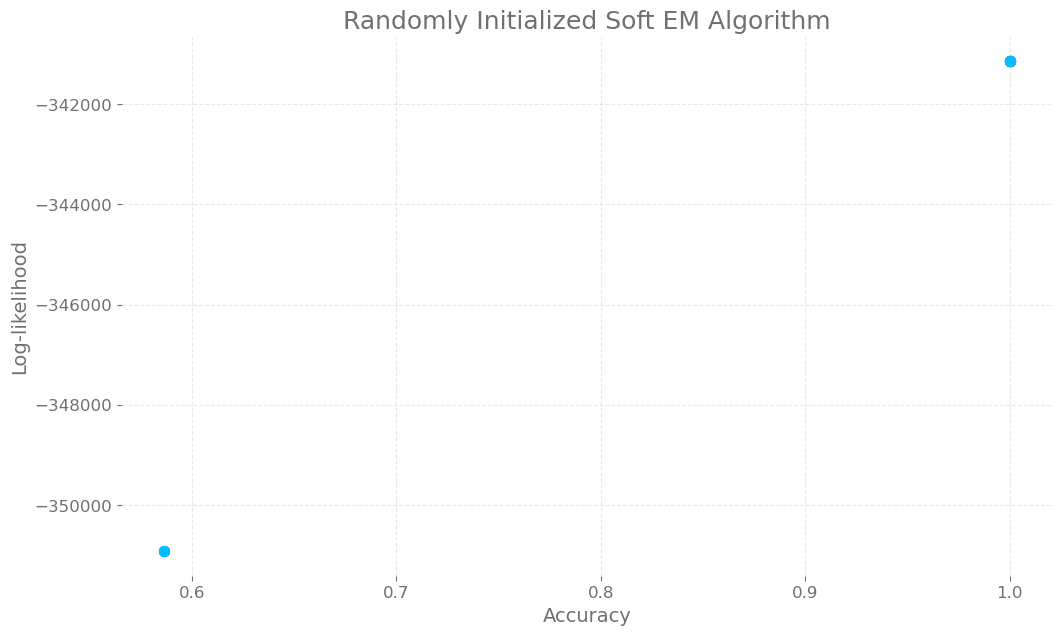

In [41]:
plt.figure(figsize=(12,7))
plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)], 
            logliksemsoft)
print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
plt.ticklabel_format(style='plain',useOffset=False)
plt.xlabel('Accuracy')
plt.ylabel('Log-likelihood')
plt.title('Randomly Initialized Soft EM Algorithm')

(array([ 5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 25.]),
 array([0.58663862, 0.62797476, 0.6693109 , 0.71064704, 0.75198317,
        0.79331931, 0.83465545, 0.87599159, 0.91732772, 0.95866386,
        1.        ]),
 <BarContainer object of 10 artists>)

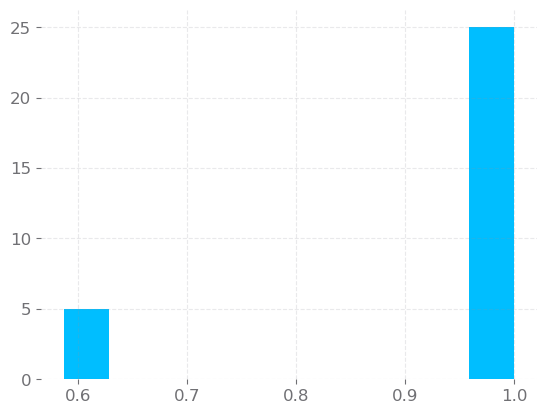

In [42]:
plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)])

(array([ 9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 21.]),
 array([0.58193109, 0.62373798, 0.66554487, 0.70735176, 0.74915865,
        0.79096554, 0.83277244, 0.87457933, 0.91638622, 0.95819311,
        1.        ]),
 <BarContainer object of 10 artists>)

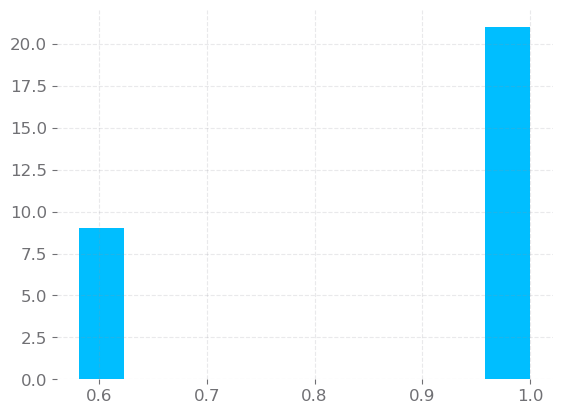

In [43]:
plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem])